# MAIN

In [1]:
# ========== 0. MAIN ==========

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import datetime
import random

# Data Loading & Preprocessing

In [ ]:
# ========== 1. Data Loading & Preprocessing ==========

# Update the file paths if the CSV files are in a different directory.
features = pd.read_csv("features-daily_2024-11_dairy.csv", 
                       parse_dates=['daydate', 'currentlastsalesdate', 'currentlastreceiptdate', 'lastsalesdate', 'storeDate'])
labels = pd.read_csv("labels_2024-11_dairy.csv", 
                     parse_dates=['storeDate', 'historyTime', 'outOfShelfTime', 'PlannedAbandonmentDate'])
trxn = pd.read_csv("trxn_2024-11_dairy.csv", 
                   parse_dates=['TransactionDate', 'TransactionTime', 'TransactionInitiatedTimestamp', 
                                'TransactionLineItemScanTimestamp', 'TransactionLineItemScanUTCTimestamp'])

# Remove holiday data (Thanksgiving) based on the assumption that Thanksgiving is on 2024-11-28.
# If you have more holiday dates or a different approach, update this section accordingly.
holiday_date = pd.Timestamp('2024-11-28')
features = features[features['daydate'] != holiday_date]
labels = labels[labels['storeDate'] != holiday_date]
trxn = trxn[trxn['TransactionDate'] != holiday_date]

# Drop duplicates if any
features.drop_duplicates(inplace=True)
labels.drop_duplicates(inplace=True)
trxn.drop_duplicates(inplace=True)

# Phantom Inventory Flagging

In [3]:
# ========== 2. Phantom Inventory Flagging ==========

# Aggregate the transaction data to the daily level per SKU.
# For example, summing total quantity and counting the number of transactions.
trxn_agg = trxn.groupby(['ItemSku', 'TransactionDate']).agg({
    'TotalItemQuantity': 'sum',    # Total quantity sold in transactions
    'TransactionId': 'nunique',    # Number of unique transactions
    'Quantity': 'sum',             # Alternatively, use Quantity if it captures sold units
    'VoidIndicator': 'sum'         # Sum here gives number of voided transactions per day
}).reset_index()

# Rename columns to align with the features dataset
trxn_agg.rename(columns={
    'ItemSku': 'itemsku', 
    'TransactionDate': 'daydate',
    'TotalItemQuantity': 'trxn_total_qty',
    'TransactionId': 'trxn_count',
    'Quantity': 'trxn_quantity',
    'VoidIndicator': 'void_count'
}, inplace=True)

# Merge aggregated transaction data with features based on itemsku and daydate.
features = features.merge(trxn_agg, on=['itemsku', 'daydate'], how='left')
# Fill missing transaction data with 0. # Fill missing values (i.e., days with no transactions) with 0
features['trxn_total_qty'] = features['trxn_total_qty'].fillna(0)
features['trxn_count'] = features['trxn_count'].fillna(0)
features['trxn_quantity'] = features['trxn_quantity'].fillna(0)
features['void_count'] = features['void_count'].fillna(0)

# Merge the features and labels data on product identifier and date.
# Here, we assume the join keys are: 'itemsku' in features and 'ItemSku' in labels,
# and that 'daydate' in features corresponds to 'storeDate' in labels.
merged = pd.merge(
    features, 
    labels, 
    left_on=['itemsku', 'daydate'], 
    right_on=['ItemSku', 'storeDate'], 
    how='left')

# Merge aggregated transaction data with the merged features/labels dataset.
merged = pd.merge(merged, trxn_agg, on=['itemsku', 'daydate'], how='left')

# Rule 1: If the product is flagged as out-of-shelf in labels (i.e. outOfShelf is True) 
# and the reported current balance on hand (DailyBOH) is greater than 0,
# then it may be a phantom inventory.
merged['phantom_flag'] = np.where((merged['outOfShelf'] == True) & (merged['DailyBOH'] > 0), 1, 0)

# Rule 2 (alternative/additional): If, for example, the product is reported as in-stock (PositiveBOHFlag==1),
# but there are no sales (salesQuantity == 0) and there is an out-of-stock count (OOSCount > 0),
# then flag it as phantom.
merged['phantom_flag'] = np.where( (merged['phantom_flag'] == 1) | 
                                   ((merged['PositiveBOHFlag'] == 1) & 
                                    (merged['salesQuantity'] == 0) & 
                                    (merged['OOSCount'] > 0)), 1, 0)

# Features Engineering

In [4]:
# ========== 3. Features Engineering ==========

# 1. Create a missingness indicator
merged['avg_sales_50to8_missing'] = merged['avg_sales_50to8'].isna().astype(int)

# 2. Create a missingness indicator for 'avg_sales_last7'
merged['avg_sales_last7_missing'] = merged['avg_sales_last7'].isna().astype(int)

# 3. Create an indicator feature for missing CurrentBOH
merged["CurrentBOH_missing"] = merged["CurrentBOH"].isna().astype(int)

# 4. Impute CurrentBOH
#    You can still do forward-fill/backward-fill or a median fill approach
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].ffill()
merged["CurrentBOH"] = merged.groupby("storeid")["CurrentBOH"].bfill()

# 5.  Create a missing indicator feature that flags which rows originally had missing IMSQuantity.
merged["IMSQuantity_missing"] = merged["IMSQuantity"].isna().astype(int)

# 6. Create a sales gap feature
if "DmdForecastQuantity" in merged.columns and "salesQuantity" in merged.columns:
    merged["sales_gap"] = merged["DmdForecastQuantity"] - merged["salesQuantity"]
else:
    merged["sales_gap"] = np.nan

# 7. Convert day of week to string category if numeric
if "DayofWeek" in merged.columns:
    merged["DayofWeek"] = merged["DayofWeek"].astype(str)

# 8. Forecast Gap Feature: Difference between lead-time and daily demand forecast quantities.
if "LDEFForecastQuantity" in merged.columns and "DmdForecastQuantity" in merged.columns:
    merged["forecast_gap"] = merged["LDEFForecastQuantity"] - merged["DmdForecastQuantity"]
else:
    merged["forecast_gap"] = np.nan

# 9. BOH to MDQ Ratio: Ratio of Current Balance On Hand to Minimum Distribution Quantity.
if "CurrentBOH" in merged.columns and "MDQ" in merged.columns:
    merged["boh_mdq_ratio"] = merged.apply(lambda x: x["CurrentBOH"] / x["MDQ"] if x["MDQ"] != 0 else np.nan, axis=1)
else:
    merged["boh_mdq_ratio"] = np.nan

# 10. Sales to Inventory Ratio: Ratio of sales quantity to DailyBOH (adding 1 to avoid division by zero).
if "salesQuantity" in merged.columns and "DailyBOH" in merged.columns:
    merged["sales_to_inventory_ratio"] = merged["salesQuantity"] / (merged["DailyBOH"] + 1)
else:
    merged["sales_to_inventory_ratio"] = np.nan

# 11. Weekend Indicator:
#    Create a binary flag if the day of the week is Saturday or Sunday.
#    (Assuming DayofWeek has been converted to string as done earlier.)
merged["is_weekend"] = merged["DayofWeek"].apply(lambda x: 1 if x in ["6", "7"] else 0)

# 12. Ensure date columns are in datetime format
date_cols = ['daydate', 'outOfShelfTime', 'currentlastreceiptdate', 'lastsalesdate']
for col in date_cols:
    if col in merged.columns:
        merged[col] = pd.to_datetime(merged[col], errors='coerce')

# 13. Out-of-Stock Duration
if 'daydate' in merged.columns and 'outOfShelfTime' in merged.columns:
    merged['out_of_stock_duration'] = (merged['daydate'] - merged['outOfShelfTime']).dt.days
    merged['out_of_stock_duration'] = merged['out_of_stock_duration'].fillna(-1)  # -1 for no OOS event
else:
    merged['out_of_stock_duration'] = np.nan

# Prepare data for classification:
# Here we select a subset of numerical features plus the cat. 
model_data = merged.copy()

feature_columns = ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount',
                   'sales_gap', 'DayofWeek', 'forecast_gap', 'avg_sales_50to8_missing',
                   'avg_sales_last7_missing', 'CurrentBOH_missing', 'IMSQuantity_missing',
                   'boh_mdq_ratio', 'sales_to_inventory_ratio',
                   'is_weekend', 'out_of_stock_duration']
target_column = 'phantom_flag'

# [LSTM] Model Building: Phantom Inventory Classifier

Using numeric cols: ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount', 'sales_gap', 'forecast_gap', 'boh_mdq_ratio', 'sales_to_inventory_ratio', 'out_of_stock_duration']
Using categorical cols: ['DayofWeek']
Final seq_features: ['salesQuantity', 'CurrentBOH', 'DailyBOH', 'IMSQuantity', 'OOSCount', 'sales_gap', 'forecast_gap', 'boh_mdq_ratio', 'sales_to_inventory_ratio', 'out_of_stock_duration', 'DayofWeek']
Sequence features now: ['num__salesQuantity', 'num__CurrentBOH', 'num__DailyBOH', 'num__IMSQuantity', 'num__OOSCount', 'num__sales_gap', 'num__forecast_gap', 'num__boh_mdq_ratio', 'num__sales_to_inventory_ratio', 'num__out_of_stock_duration', 'cat__DayofWeek_1', 'cat__DayofWeek_2', 'cat__DayofWeek_3', 'cat__DayofWeek_4', 'cat__DayofWeek_5', 'cat__DayofWeek_6', 'cat__DayofWeek_7']
Train sequences: (113715, 30, 17) Test sequences: (33499, 30, 17)
Epoch 1/40


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


400/400 - 22s - 54ms/step - auc: 0.7952 - loss: 0.2323 - val_auc: 0.8706 - val_loss: 0.2344
Epoch 2/40
400/400 - 20s - 51ms/step - auc: 0.8665 - loss: 0.1750 - val_auc: 0.8770 - val_loss: 0.2207
Epoch 3/40
400/400 - 21s - 52ms/step - auc: 0.8919 - loss: 0.1578 - val_auc: 0.8761 - val_loss: 0.2252
Epoch 4/40
400/400 - 21s - 52ms/step - auc: 0.9037 - loss: 0.1488 - val_auc: 0.8757 - val_loss: 0.2239
Epoch 5/40
400/400 - 21s - 53ms/step - auc: 0.9175 - loss: 0.1398 - val_auc: 0.8750 - val_loss: 0.2361
Epoch 6/40
400/400 - 20s - 51ms/step - auc: 0.9303 - loss: 0.1310 - val_auc: 0.8776 - val_loss: 0.2578
Epoch 7/40
400/400 - 21s - 52ms/step - auc: 0.9393 - loss: 0.1247 - val_auc: 0.8770 - val_loss: 0.2586
Epoch 8/40
400/400 - 21s - 52ms/step - auc: 0.9481 - loss: 0.1177 - val_auc: 0.8752 - val_loss: 0.2601
Epoch 9/40
400/400 - 21s - 52ms/step - auc: 0.9541 - loss: 0.1116 - val_auc: 0.8747 - val_loss: 0.2771
Epoch 10/40
400/400 - 21s - 52ms/step - auc: 0.9594 - loss: 0.1074 - val_auc: 0.8651

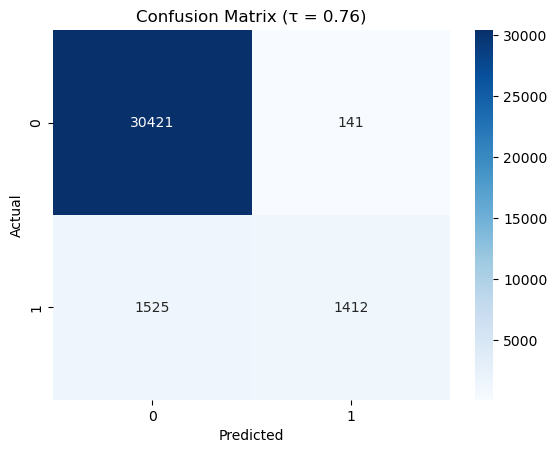

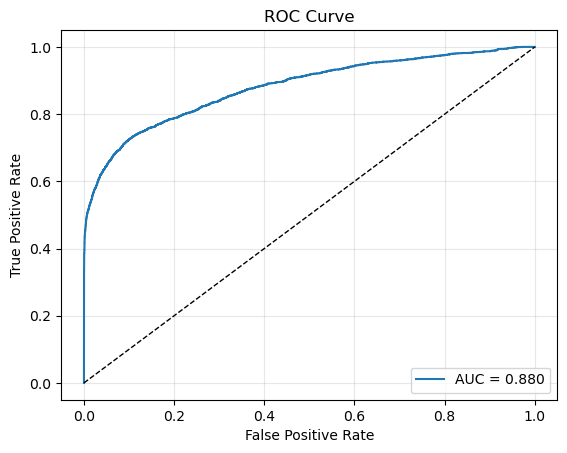

In [ ]:
# ========== 4. [LSTM] Model Building | Phantom Inventory Classifier ==========

# =============================================================
# 0.  Imports
# =============================================================
# ─── reproducibility boilerplate ───
import os, random
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(42)
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

import numpy as np, pandas as pd, tensorflow as tf, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (precision_recall_curve, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             confusion_matrix, roc_curve, auc)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras import layers, models, callbacks

# =============================================================
# 1.  Parameters
# =============================================================
DATE_COL   = 'daydate'      # timestamp column
GROUP_COL  = 'itemsku'      # SKU identifier
LABEL_COL  = 'phantom_flag'
SEQ_LEN    = 30             # days in each sequence
PREC_FLOOR = 0.95           # precision requirement
                            # The function guaranteed P ≥ 0.90 on the reference set (X_train),
                            # When applied to unseen SKUs in X_test, the class mix and feature patterns shift a bit, so I increased here.

# features used inside each timestep
num_cols = ['salesQuantity','CurrentBOH','DailyBOH','IMSQuantity','OOSCount',
            'sales_gap','forecast_gap','avg_sales_50to8_imputed',
            'avg_sales_last7_imputed','boh_mdq_ratio','sales_to_inventory_ratio',
            'stock_turnover_ratio_7d', 'out_of_stock_duration']
cat_cols = ['DayofWeek']    # will be one‑hot encoded
seq_features = num_cols + cat_cols

# =============================================================
# 2.  Step‑A:  make fixed‑length sequences  (pad left w/ zeros if <SEQ_LEN)
# =============================================================
def build_sequences(df, seq_len=SEQ_LEN):
    """Return X (n_seq, seq_len, n_feat) and y (n_seq,) with group isolation."""
    X_list, y_list = [], []
    # 1) sort by group & date
    df = df.sort_values([GROUP_COL, DATE_COL])
    for sku, grp in df.groupby(GROUP_COL):
        # rolling window with step = 1
        for i in range(len(grp)):
            end = i + 1
            start = max(0, end - seq_len)
            window = grp.iloc[start:end]
            # skip if label missing
            label = window[LABEL_COL].iloc[-1]
            # pad on the left if shorter than seq_len
            pad_len = seq_len - len(window)
            feat_window = window[seq_features].to_numpy(dtype='float32')
            if pad_len > 0:
                pad = np.zeros((pad_len, feat_window.shape[1]), dtype='float32')
                feat_window = np.vstack([pad, feat_window])
            X_list.append(feat_window)
            y_list.append(label)
    X = np.stack(X_list)
    y = np.array(y_list, dtype='int8')
    return X, y

# ──────────────────────────────────────
# Prune numeric & categorical lists to available columns
# ──────────────────────────────────────
avail = set(model_data.columns)
num_cols = [c for c in num_cols if c in avail]
cat_cols = [c for c in cat_cols if c in avail]
# Rebuild seq_features from these two lists
seq_features = num_cols + cat_cols

print("Using numeric cols:", num_cols)
print("Using categorical cols:", cat_cols)
print("Final seq_features:", seq_features)

# =============================================================
# 3.  Pre‑processing:  numeric scaler + one‑hot, **row‑wise**
# =============================================================
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # no more NaNs
    ('scaler',  StandardScaler())
])
pre = ColumnTransformer(
        [('num', num_pipeline, num_cols),
         ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
        remainder='drop'
)

# 3a) scale all features row‑wise
features_scaled = pre.fit_transform(model_data[seq_features])

# reconstruct feat_df
feat_df = pd.DataFrame(
    features_scaled,
    columns=pre.get_feature_names_out()
)
feat_df[[GROUP_COL, DATE_COL, LABEL_COL]] = model_data[
    [GROUP_COL, DATE_COL, LABEL_COL]
].reset_index(drop=True)

# ────────────────────────────────────────
# Reset seq_features to the scaled/encoded columns
# ────────────────────────────────────────
seq_features = [
    c for c in feat_df.columns
    if c not in [GROUP_COL, DATE_COL, LABEL_COL]
]
print("Sequence features now:", seq_features)

# =============================================================
# 4.  Build sequences & train‑test split (SKU‑wise)
# =============================================================
X_all, y_all = build_sequences(feat_df, SEQ_LEN)

# create group array to stratify by SKU
groups = model_data[GROUP_COL].values
uniq_skus = np.unique(groups)

# ────────────────────────────────────────────────
# NEW: just split the unique SKUs into train/test
train_skus, test_skus = train_test_split(
    uniq_skus,
    test_size=0.2,
    random_state=42  # no stratify here
)
# ────────────────────────────────────────────────

train_mask = np.isin(feat_df[GROUP_COL].iloc[-len(y_all):], train_skus)  # last len(y_all) rows correspond
X_train, y_train = X_all[train_mask], y_all[train_mask]
X_test,  y_test  = X_all[~train_mask], y_all[~train_mask]

print("Train sequences:", X_train.shape, "Test sequences:", X_test.shape)

# =============================================================
# 5.  Build LSTM model
# =============================================================
n_feat = X_train.shape[2]
model = models.Sequential([
    layers.Masking(mask_value=0., input_shape=(SEQ_LEN, n_feat)),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])

early = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_auc')

history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=40,
                    batch_size=256,
                    callbacks=[early],
                    verbose=2)

# =============================================================
# 6.  Pick threshold for Precision ≥ PREC_FLOOR on training set
# =============================================================
train_pred = model.predict(X_train, batch_size=512).ravel()
prec, rec, thr = precision_recall_curve(y_train, train_pred)
idx = np.where(prec[:-1] >= PREC_FLOOR)[0]
if len(idx) == 0:
    raise ValueError(f"Cannot reach precision {PREC_FLOOR}")
tau = thr[idx[0]]
print(f"Threshold for P≥{PREC_FLOOR}: τ = {tau:.2f}")

# =============================================================
# 7.  Evaluate on test set
# =============================================================
test_pred = model.predict(X_test, batch_size=512).ravel()
y_hat = (test_pred >= tau).astype(int)

print("Test Precision:", precision_score(y_test, y_hat))
print("Test Recall   :", recall_score(y_test, y_hat))
print("Test F1       :", f1_score(y_test, y_hat))
print("Test ROC‑AUC  :", roc_auc_score(y_test, test_pred))

# =============================================================
# 8.  Plots
# =============================================================
cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (τ = {tau:.2f})')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

fpr, tpr, _ = roc_curve(y_test, test_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(loc='lower right'); plt.grid(alpha=0.3); plt.show()

# Model Evaluation
# SHAP Explanation

Attempting SHAP analysis using KernelExplainer (adapted for 3D input).
Initializing KernelExplainer...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Calculating SHAP values using KernelExplainer for 10 test samples (reshaped input)...


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1892/1892 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1878/1878 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1880/1880 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1879/1879 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1878/1878 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Kernel SHAP values (flat) calculated in 76.81 seconds.
Overall mean absolute SHAP value: 0.0024089256284518237


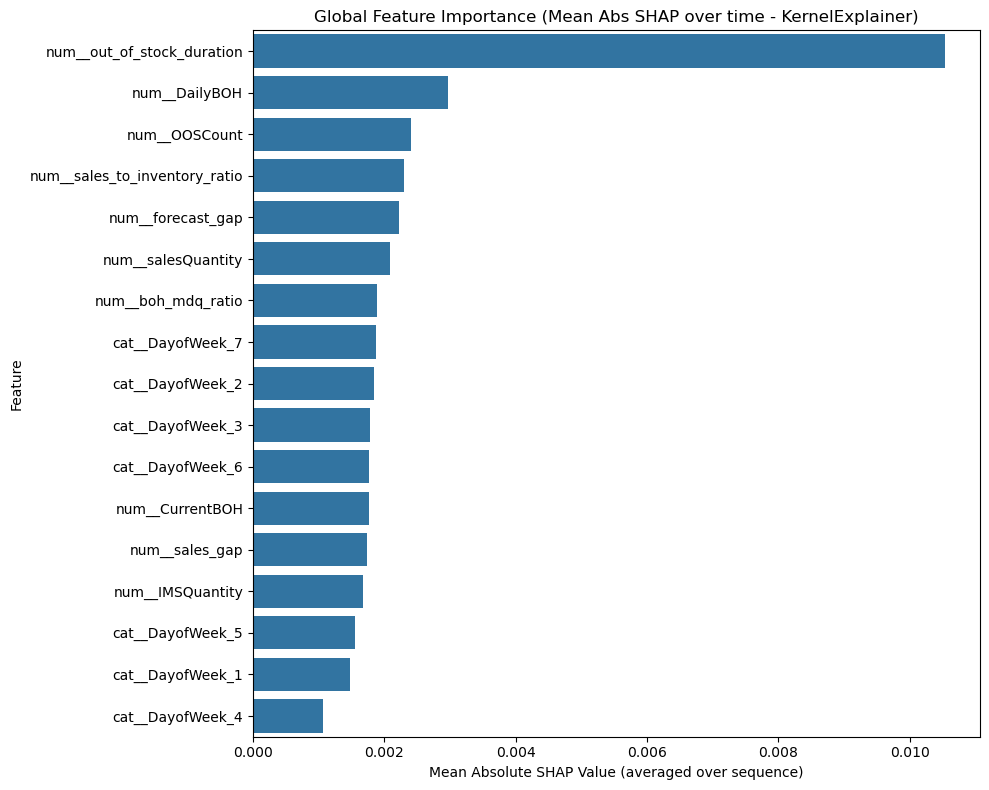

Manual feature importance bar plot should have been displayed.

--- Debugging info for SHAP Summary Plot ---
shap_values_orig_features_time_avg shape: (10, 17)
features_for_summary_plot_orig_time_avg shape: (10, 17)
seq_features length: 17
Sample of shap_values_orig_features_time_avg[0,0]: 0.001781294484533206
Sample of features_for_summary_plot_orig_time_avg[0,0]: 3.4217896461486816
seq_features: ['num__salesQuantity', 'num__CurrentBOH', 'num__DailyBOH', 'num__IMSQuantity', 'num__OOSCount']
NaNs in shap_values_orig_features_time_avg: False
Infs in shap_values_orig_features_time_avg: False
NaNs in features_for_summary_plot_orig_time_avg: False
Infs in features_for_summary_plot_orig_time_avg: False

Displaying SHAP Summary Plot (time-averaged values - KernelExplainer)...
Attempting summary_plot (dot) with show=False then plt.show()...


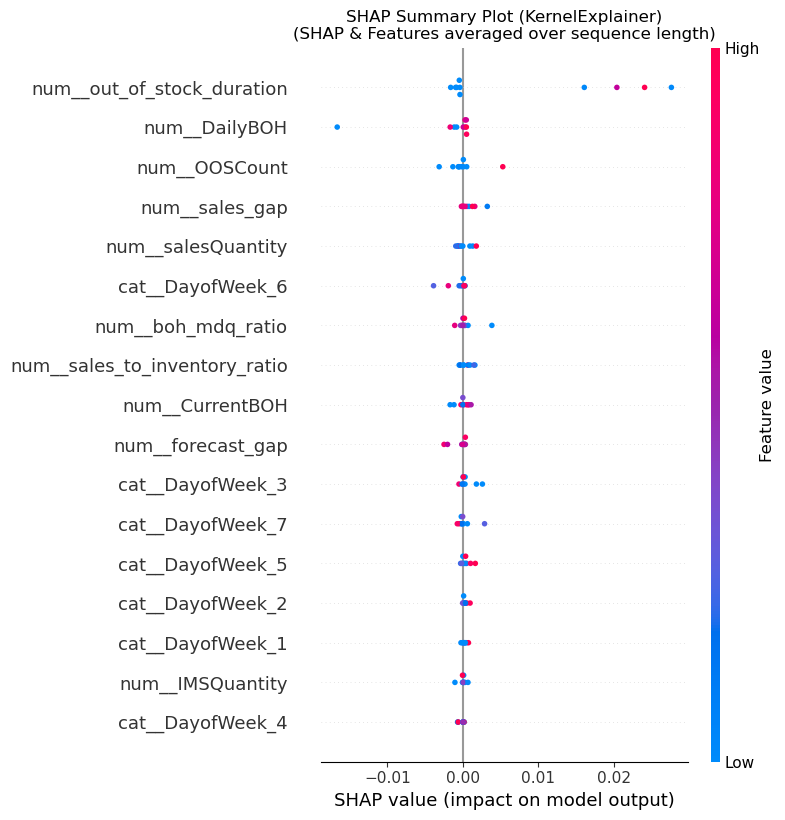

Dot summary plot attempt finished.

Attempting summary_plot (bar) with show=False then plt.show()...


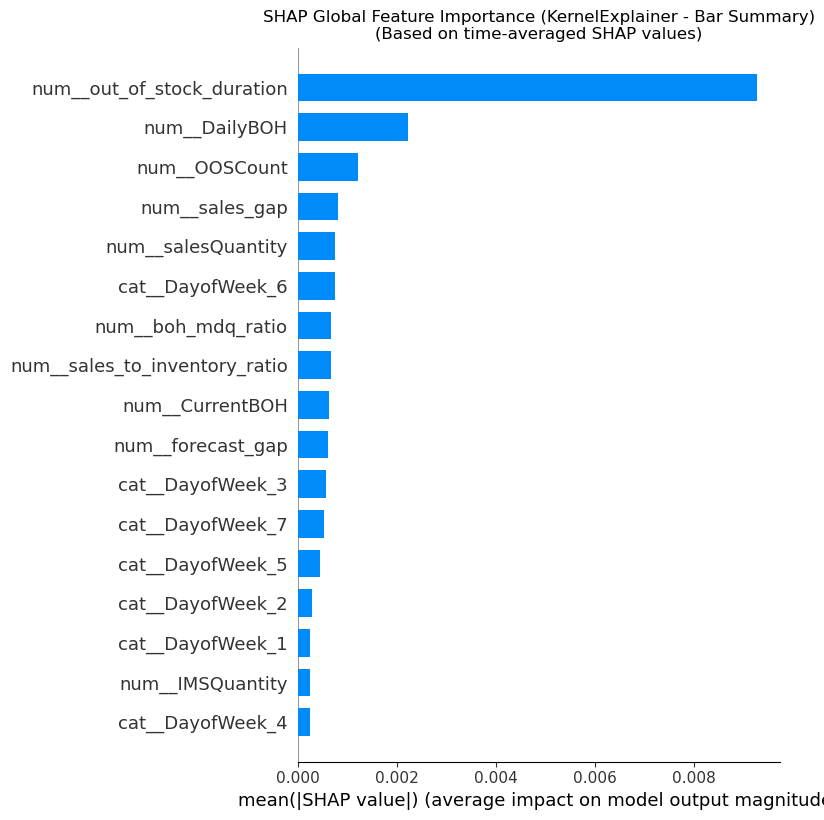

Bar summary plot attempt finished.

Attempting summary_plot (dot) with show=True (basic call)...


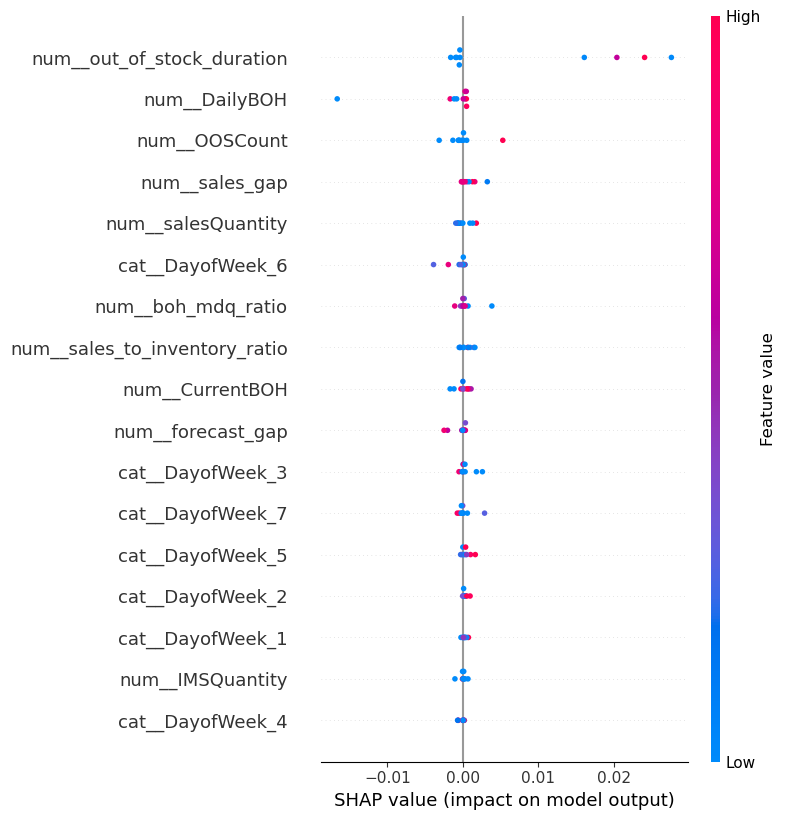

Basic dot summary plot (show=True) attempt finished.

Attempting summary_plot (bar) with show=True (basic call)...


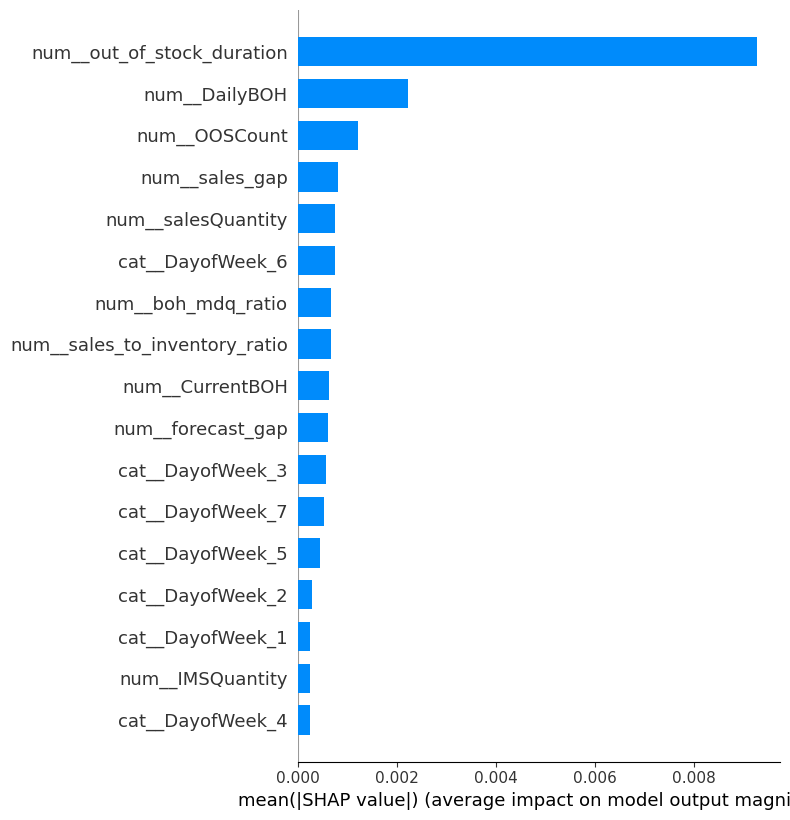

Basic bar summary plot (show=True) attempt finished.


In [ ]:
# ========== 6. [LSTM] Model Evaluation: Feature Importance & SHAP Explanations ==========

# =============================================================
# 9.  Feature Importance and SHAP Analysis (Using KernelExplainer - Corrected for 3D input)
# =============================================================
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- Ensure X_train and X_test are available and have the correct shape ---
# X_train shape: (n_train_samples, SEQ_LEN, n_feat)
# X_test shape: (n_test_samples, SEQ_LEN, n_feat)

if 'X_train' not in globals() or X_train.shape[0] == 0:
    print("X_train is not defined or is empty. Cannot proceed with SHAP analysis.")
elif 'X_test' not in globals() or X_test.shape[0] == 0:
    print("X_test is not defined or is empty. Cannot proceed with SHAP analysis.")
else:
    # Get sequence length and number of features per step from training data
    # These should match your model's expected input dimensions
    if len(X_train.shape) != 3:
        print(f"X_train is not 3-dimensional (shape: {X_train.shape}). KernelExplainer adaptation requires 3D input (samples, seq_len, features_per_step).")
    else:
        _SEQ_LEN = X_train.shape[1]
        _N_FEAT_PER_STEP = X_train.shape[2] # This should be len(seq_features)

        # --- Check if seq_features matches the number of features per step ---
        if len(seq_features) != _N_FEAT_PER_STEP:
            print(f"Warning: Length of seq_features ({len(seq_features)}) does not match N_FEAT_PER_STEP from X_train ({_N_FEAT_PER_STEP}). Ensure seq_features is correct.")
            # Potentially override _N_FEAT_PER_STEP if seq_features is considered the source of truth for feature count
            # _N_FEAT_PER_STEP = len(seq_features)

        n_background_samples = min(20, X_train.shape[0]) # Reduced for KernelExplainer speed & memory
        n_test_samples_for_shap = min(10, X_test.shape[0]) # REDUCED significantly for KernelExplainer

        print("Attempting SHAP analysis using KernelExplainer (adapted for 3D input).")

        # 1. Reshape background data
        background_indices = np.random.choice(X_train.shape[0], n_background_samples, replace=False)
        background_data_3d = X_train[background_indices]
        background_data_kernel_reshaped = background_data_3d.reshape(n_background_samples, _SEQ_LEN * _N_FEAT_PER_STEP)

        # 2. Reshape test data for explanation
        test_indices_for_shap = np.random.choice(X_test.shape[0], n_test_samples_for_shap, replace=False)
        data_for_shap_explanation_3d = X_test[test_indices_for_shap]
        data_for_shap_explanation_reshaped = data_for_shap_explanation_3d.reshape(n_test_samples_for_shap, _SEQ_LEN * _N_FEAT_PER_STEP)

        # 3. Modify predict_fn to handle reshaped input
        def predict_fn_reshaped(x_reshaped):
            # x_reshaped is (num_perturbations, _SEQ_LEN * _N_FEAT_PER_STEP)
            num_perturbations = x_reshaped.shape[0]
            # Reshape back to 3D for the model
            x_3d = x_reshaped.reshape(num_perturbations, _SEQ_LEN, _N_FEAT_PER_STEP)
            predictions = model.predict(x_3d) # model is your trained LSTM model
            # For binary classification with sigmoid, model.predict gives (N, 1)
            # KernelExplainer often expects (N,) or (N, n_classes) for multi-class
            return predictions.ravel() # Ensure output is (N,) for binary case

        # Initialize KernelExplainer
        print("Initializing KernelExplainer...")
        # It's good practice to use shap.sample for background data with KernelExplainer if resources permit
        # For now, using the randomly sampled and reshaped background data.
        # If background_data_kernel_reshaped is large, consider:
        # summarized_background = shap.sample(background_data_kernel_reshaped, 50) # e.g., 50 summary points
        # kernel_explainer = shap.KernelExplainer(predict_fn_reshaped, summarized_background)
        kernel_explainer = shap.KernelExplainer(predict_fn_reshaped, background_data_kernel_reshaped)

        # Calculate SHAP values (THIS WILL BE VERY SLOW!)
        print(f"Calculating SHAP values using KernelExplainer for {n_test_samples_for_shap} test samples (reshaped input)...")
        start_time = time.time()
        # The shap_values will be for the flattened features
        shap_values_kernel_flat = kernel_explainer.shap_values(data_for_shap_explanation_reshaped)
        end_time = time.time()
        print(f"Kernel SHAP values (flat) calculated in {end_time - start_time:.2f} seconds.")
        # shap_values_kernel_flat shape: (n_test_samples_for_shap, _SEQ_LEN * _N_FEAT_PER_STEP)

        # 4. Reshape SHAP values back to (samples, seq_len, features_per_step) for easier interpretation
        shap_values_kernel_3d = shap_values_kernel_flat.reshape(n_test_samples_for_shap, _SEQ_LEN, _N_FEAT_PER_STEP)

        # --- Plotting ---
        # Now, for global feature importance and summary plots, we typically average SHAP values over the time dimension
        # to get an importance score for each of the original _N_FEAT_PER_STEP features.

        # 9.1. Global Feature Importance (derived from time-averaged SHAP values)
        # This part worked for you, so we assume shap_values_kernel_3d and seq_features are valid.
        mean_abs_shap_overall = np.abs(shap_values_kernel_3d).mean(axis=(0, 1, 2)) # A single value for overall impact
        print(f"Overall mean absolute SHAP value: {mean_abs_shap_overall}") # Just a sanity check

        mean_abs_shap_time_averaged = np.abs(shap_values_kernel_3d).mean(axis=(0,1)) # Average over samples and time for each feature

        if len(seq_features) == len(mean_abs_shap_time_averaged):
            feature_importance_shap = pd.Series(mean_abs_shap_time_averaged, index=seq_features)
            feature_importance_shap = feature_importance_shap.sort_values(ascending=False)

            plt.figure(figsize=(10, 8))
            sns.barplot(x=feature_importance_shap.values, y=feature_importance_shap.index)
            plt.title('Global Feature Importance (Mean Abs SHAP over time - KernelExplainer)')
            plt.xlabel('Mean Absolute SHAP Value (averaged over sequence)')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()
            print("Manual feature importance bar plot should have been displayed.")
        else:
            print(f"Error: Mismatch between len(seq_features)={len(seq_features)} and len(mean_abs_shap_time_averaged)={len(mean_abs_shap_time_averaged)}")

        # 9.2. SHAP Summary Plot (using SHAP values averaged over time for original features)
        # SHAP values averaged over time for each sample and each original feature:
        shap_values_orig_features_time_avg = shap_values_kernel_3d.mean(axis=1) # Shape: (n_samples, _N_FEAT_PER_STEP)

        # Corresponding feature values, also averaged over time for consistency in the plot:
        features_for_summary_plot_orig_time_avg = data_for_shap_explanation_3d.mean(axis=1) # Shape: (n_samples, _N_FEAT_PER_STEP)

        # --- DEBUGGING PRINTS ---
        print("\n--- Debugging info for SHAP Summary Plot ---")
        print(f"shap_values_orig_features_time_avg shape: {shap_values_orig_features_time_avg.shape}")
        print(f"features_for_summary_plot_orig_time_avg shape: {features_for_summary_plot_orig_time_avg.shape}")
        print(f"seq_features length: {len(seq_features)}")
        if shap_values_orig_features_time_avg.shape[0] > 0 and shap_values_orig_features_time_avg.shape[1] > 0 :
            print(f"Sample of shap_values_orig_features_time_avg[0,0]: {shap_values_orig_features_time_avg[0,0]}")
            print(f"Sample of features_for_summary_plot_orig_time_avg[0,0]: {features_for_summary_plot_orig_time_avg[0,0]}")
        else:
            print("One of the dimensions for shap_values or features is 0, plotting will likely fail.")

        print(f"seq_features: {seq_features[:5]}") # Print first 5 feature names

        # Check for NaNs or Infs which might cause plotting issues
        print(f"NaNs in shap_values_orig_features_time_avg: {np.isnan(shap_values_orig_features_time_avg).any()}")
        print(f"Infs in shap_values_orig_features_time_avg: {np.isinf(shap_values_orig_features_time_avg).any()}")
        print(f"NaNs in features_for_summary_plot_orig_time_avg: {np.isnan(features_for_summary_plot_orig_time_avg).any()}")
        print(f"Infs in features_for_summary_plot_orig_time_avg: {np.isinf(features_for_summary_plot_orig_time_avg).any()}")
        # --- END DEBUGGING PRINTS ---

        print("\nDisplaying SHAP Summary Plot (time-averaged values - KernelExplainer)...")
        try:
            # Attempt 1: Standard way (as you had it)
            print("Attempting summary_plot (dot) with show=False then plt.show()...")
            shap.summary_plot(shap_values_orig_features_time_avg,
                            features=features_for_summary_plot_orig_time_avg,
                            feature_names=seq_features,
                            plot_type="dot",
                            show=False)
            plt.title('SHAP Summary Plot (KernelExplainer)\n(SHAP & Features averaged over sequence length)')
            plt.tight_layout()
            plt.show()
            print("Dot summary plot attempt finished.")

            # Attempt 2: Simplest call for the bar plot
            print("\nAttempting summary_plot (bar) with show=False then plt.show()...")
            shap.summary_plot(shap_values_orig_features_time_avg, # For bar plot, features argument is not strictly needed but often provided
                            features=features_for_summary_plot_orig_time_avg,
                            feature_names=seq_features,
                            plot_type="bar",
                            show=False)
            plt.title('SHAP Global Feature Importance (KernelExplainer - Bar Summary)\n(Based on time-averaged SHAP values)')
            plt.tight_layout()
            plt.show()
            print("Bar summary plot attempt finished.")

            # Attempt 3: Very basic call with show=True to see if SHAP itself can show it
            if shap_values_orig_features_time_avg.shape[0] > 0 and shap_values_orig_features_time_avg.shape[1] > 0:
                print("\nAttempting summary_plot (dot) with show=True (basic call)...")
                shap.summary_plot(shap_values_orig_features_time_avg,
                                features=features_for_summary_plot_orig_time_avg,
                                feature_names=seq_features,
                                plot_type="dot",
                                show=True) # Let SHAP handle showing the plot directly
                print("Basic dot summary plot (show=True) attempt finished.")

                print("\nAttempting summary_plot (bar) with show=True (basic call)...")
                shap.summary_plot(shap_values_orig_features_time_avg,
                                feature_names=seq_features,
                                plot_type="bar",
                                show=True)
                print("Basic bar summary plot (show=True) attempt finished.")
            else:
                print("Skipping basic show=True attempts due to empty data dimensions.")

        except Exception as e:
            print(f"!!!!!!!!!! An error occurred during SHAP summary plot generation: {e} !!!!!!!!!!")
            import traceback
            traceback.print_exc()

# Model Deployment

In [ ]:
# ========== 7. [LSTM] Model Deployment ==========

# -- 1: save the trained pipeline --
import joblib
joblib.dump(model, '.../phantom-inventory-model/lstm/model/phantom_lstm_pipeline.pkl')

# -- 2: save the threshold --
import json, os
os.makedirs('model', exist_ok=True)
with open('.../phantom-inventory-model/lstm/model/threshold.json', 'w') as f:
    json.dump({"precision_floor_threshold": 0.76}, f)